<a href="https://colab.research.google.com/github/who-knows-its-nebulose/Chair_Style_classifier/blob/main/classification_chair.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
ls "/content/drive/My Drive/Colab Notebooks/checkpoints/"

In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

img_height = 224
img_width = 224
batch_size = 16

In [4]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names = ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "training",
)

ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/Colab Notebooks/chairs/',
    labels = 'inferred',
    label_mode = "categorical",
    class_names= ["Farmhouse", "Industrial", "Midcentury","Tropical","Victorian"],
    color_mode = 'rgb',
    batch_size = batch_size,
    image_size = (img_height, img_width),
    shuffle = True, #(why?)
    seed = 123,
    validation_split = 0.2,
    subset = "validation",
)


  

Found 1705 files belonging to 5 classes.
Using 1364 files for training.
Found 1705 files belonging to 5 classes.
Using 341 files for validation.


In [5]:
class_names = ds_train.class_names
print(class_names)

['Farmhouse', 'Industrial', 'Midcentury', 'Tropical', 'Victorian']


In [6]:
#look at the dataset

# plt.figure(figsize=(10, 10))
# for images, labels in ds_train.take(1):
#   for i in range(16):
#     ax = plt.subplot(4, 4, i + 1)
#     plt.imshow(np.squeeze(images[i].numpy().astype("uint8")))
#     int_labels = np.argmax(labels, axis=-1)
#     plt.title(class_names[int_labels[i]])
#     plt.axis("off")

Augment and rescale

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
IMG_SIZE = 224

# resize_and_rescale = tf.keras.Sequential([
#   layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
#   layers.experimental.preprocessing.Rescaling(1./255)
# ])

img_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
  ]
)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
#rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

#set buffer_size to AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# ds_train = prepare(ds_train, shuffle=True, augment=True)
# ds_valid = prepare(ds_valid)

base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, 
                                                           img_width,
                                                              3),
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False
base_model.summary()

#BUILD TOP LAYERS GAP2d+Dense+Dropout+DensewithSoftmax
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_1024 = tf.keras.layers.Dense(1024, activation='relu')
dense_512 = tf.keras.layers.Dense(512, activation='relu')
dense_128 = tf.keras.layers.Dense(128, activation='relu')
drop = tf.keras.layers.Dropout(0.2)
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
# dense_128batch = dense_128(feature_batch_average)
# print(dense_128batch.shape)
# dropoutbatch=tf.keras.layers.Dropout(0.2)(dense_128batch)
# print(dropoutbatch)
# prediction_batch = prediction_layer(dropoutbatch)
# print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = img_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = drop(x)
x = dense_512(x)
x = drop(x)
# x = dense_512(x)
# x = drop(x)
x = dense_128(x)
x = drop(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)




In [8]:
# for image, label in ds_train.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         #aug_img = img_augmentation(image)
#         aug_image = img_augmentation(tf.expand_dims(image[0], axis=0))
#         plt.imshow(aug_image[0]/255)
# #        plt.title(int(labels[i]))
# #       plt.title("{}".format(format_label(label)))
#         plt.axis("off")

PREFETCH

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )

model.summary()

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE) 
ds_valid = ds_valid.prefetch(buffer_size=AUTOTUNE)

len(model.trainable_variables)



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           sequential[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 224, 224, 3) 0           tf_op_layer_RealDiv[0][0]        
_______________________________________________________________________________________

6

In [10]:
print(AUTOTUNE)

initial_epochs = 100

from keras.callbacks import *
filepath="/content/drive/My Drive/Colab_notebooks/checkpoint/epochs:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



# checkpoint_filepath = '/content/drive/My Drive/Colab_notebooks/checkpoint/cp.ckpt'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,)
#     #monitor='val_accuracy',
#     #mode='max',
#     #save_best_only=True)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
  monitor='val_accuracy',
  factor=0.5,
  patience=4,
  min_lr=1e-6
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_accuracy',
  patience=5,
  mode='max',
)



# callbacks = [
#     keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_loss",
#         # "no longer improving" being defined as "no better than 1e-2 less"
#         min_delta=1e-2,
#         # "no longer improving" being further defined as "for at least 2 epochs"
#         patience=2,
#         verbose=1,
#     )
# ]

history = model.fit(ds_train,
                    epochs=initial_epochs,
                    validation_data=ds_valid,
                    callbacks = [checkpoint, early_stopping_callback, reduce_lr_callback])

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


-1
Epoch 1/100
86/86 [==============================] - ETA: 0s - loss: 1.4194 - accuracy: 0.4076
Epoch 00001: val_accuracy improved from -inf to 0.65689, saving model to /content/drive/My Drive/Colab_notebooks/checkpoint/epochs:001-val_acc:0.657.hdf5
86/86 [==============================] - 7s 82ms/step - loss: 1.4194 - accuracy: 0.4076 - val_loss: 1.1076 - val_accuracy: 0.6569
Epoch 2/100
85/86 [============================>.] - ETA: 0s - loss: 1.0021 - accuracy: 0.6184
Epoch 00002: val_accuracy improved from 0.65689 to 0.73900, saving model to /content/drive/My Drive/Colab_notebooks/checkpoint/epochs:002-val_acc:0.739.hdf5
86/86 [==============================] - 6s 68ms/step - loss: 1.0009 - accuracy: 0.6195 - val_loss: 0.9089 - val_accuracy: 0.7390
Epoch 3/100
84/86 [============================>.] - ETA: 0s - loss: 0.8234 - accuracy: 0.7046
Epoch 00003: val_accuracy improved from 0.73900 to 0.75953, saving model to /content/drive/My Drive/Colab_notebooks/checkpoint/epochs:003-val

In [25]:
print(callbacks_list)

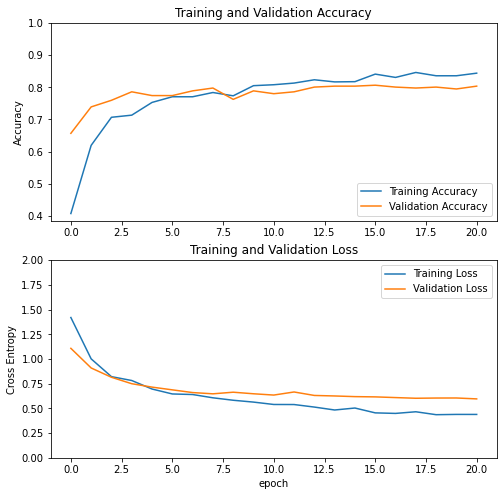

In [11]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

fine tune to see if it can improve

In [12]:


base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 20

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']
              )
model.summary()

len(model.trainable_variables)

Number of layers in the base model:  155
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_RealDiv (TensorFlow [(None, 224, 224, 3) 0           sequential[0][0]                 
__________________________________________________________________________________________________
tf_op_layer_Sub (TensorFlowOpLa [(None, 224, 224, 3) 0           tf_op_layer_RealDiv[0][0]        
______________________________________________

143

In [13]:
fine_tune_epochs =20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(ds_train,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_valid,
                         callbacks = [checkpoint, early_stopping_callback, reduce_lr_callback])

Epoch 21/120
86/86 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8328
Epoch 00021: val_accuracy improved from 0.80645 to 0.81818, saving model to /content/drive/My Drive/Colab_notebooks/checkpoint/epochs:021-val_acc:0.818.hdf5
86/86 [==============================] - 9s 103ms/step - loss: 0.4589 - accuracy: 0.8328 - val_loss: 0.5778 - val_accuracy: 0.8182
Epoch 22/120
85/86 [============================>.] - ETA: 0s - loss: 0.4134 - accuracy: 0.8537
Epoch 00022: val_accuracy did not improve from 0.81818
86/86 [==============================] - 7s 87ms/step - loss: 0.4147 - accuracy: 0.8534 - val_loss: 0.6308 - val_accuracy: 0.7947
Epoch 23/120
85/86 [============================>.] - ETA: 0s - loss: 0.3664 - accuracy: 0.8669
Epoch 00023: val_accuracy did not improve from 0.81818
86/86 [==============================] - 8s 87ms/step - loss: 0.3655 - accuracy: 0.8673 - val_loss: 0.5795 - val_accuracy: 0.8123
Epoch 24/120
85/86 [============================>.] - 

In [14]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']



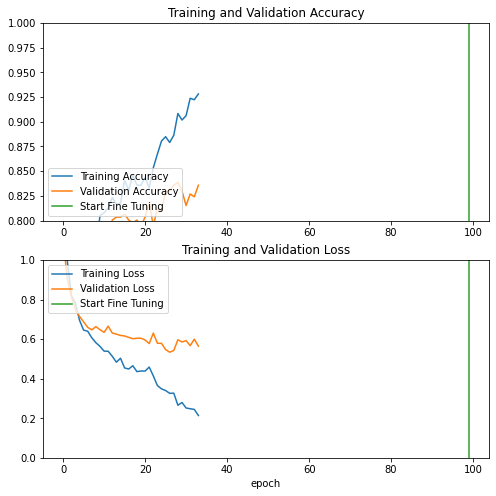

In [15]:


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#best so far model saved, 83.78

In [28]:
model.save('bb.h5')

In [ ]:
#TEST
from keras.models import load_model
from keras.preprocessing import image


model_trained = load_model('bb.h5')


img_path = '/content/drive/My Drive/Colab Notebooks/chairs_test/test/'
# img1 = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img1)
# x = np.expand_dims(x, axis=0)

# preds = model_trained.predict(x)
# print(preds)
# yy=preds[0].argmax(axis=-1)

# # np.array(X_train)[indices.astype(int)]
# predicted_chair = class_names[yy]
# print(predicted_chair)

def classify(img_name):
    img = image.load_img(img_path + '/' + img_name, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    
    prediction = model_trained.predict(img_batch)[0].argmax(axis=-1)

    print(class_names[prediction])

classify("5016victorian-armchairs-and-accent-chairs.jpg")






In [ ]:
def classify(img_name):
    img = image.load_img(img_path + '/' + img_name, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    
    prediction = model_trained.predict(img_batch)[0].argmax(axis=-1)

    print(class_names[prediction])

classify("5016victorian-armchairs-and-accent-chairs.jpg")

In [43]:
classify("17650midcentury-dining-chairs.jpg")

Midcentury


In [16]:



# N_CLASSES = 5

# #kernel_initializer = tf.keras.initializers.glorot_uniform(seed=1337)
# trained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#                       include_top=False,
#                       weights='imagenet',
#                       alpha=0.5,
#                       input_shape=[224, 224, 3],
#                       pooling='max')
# output = tf.keras.layers.Dense(N_CLASSES, activation='softmax', kernel_initializer=kernel_initializer)(trained_model.output)
# model = tf.keras.Model(inputs=trained_model.input, outputs=output)

# # Callback to save weights, based on val_acc
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#   './checkpoints/{epoch:02d}_{val_acc:.4f}.h5',
#   save_weights_only=False,
#   verbose=1,
#   monitor='val_acc',
#   save_best_only=True,
#   mode='max'
# )


In [17]:
# print(len(ds_train))

In [18]:
# # Callbackto plot data on TensorBoard
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#   log_dir='./logs/furniture_classifier',
#   histogram_freq=0,
#   batch_size=BATCH_SIZE
# )

# # Callback to reduce learning rate after plateaus
# reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
#   monitor='val_acc',
#   factor=0.5,
#   patience=4,
#   min_lr=1e-6
# )

# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#   monitor='val_acc',
#   patience=20,
#   mode='max',
# )

# TRAIN_DATASET_SIZE = len(train_batches)
# VAL_DATASET_SIZE   = len(val_batches)

# # Weighted losses for class equilibrium
# unique, counts = np.unique(ds_train.classes, return_counts=True)
# class_weigths = dict(zip(unique, np.true_divide(counts.sum(), N_CLASSES*counts)))


# if Path('./checkpoints/').exists():
#   epoch_number_array = []
#   val_accuracy_array = []
#   file_name_array = []
#   for file in os.listdir('./checkpoints/'):
#     epoch, val_acc = re.search(r'(\d\d)_(\d\.\d{4})\.h5', file).group(1,2)
#     epoch_number_array.append(int(epoch))
#     val_accuracy_array.append(float(val_acc))
#     file_name_array.append(file)

#   if len(val_accuracy_array) == 0:
#     INITIAL_EPOCH = 0
#   else:
#     highest_acc = val_accuracy_array.index(max(val_accuracy_array))
#     INITIAL_EPOCH = epoch_number_array[highest_acc]
#     model_checkpoint_callback.best = val_accuracy_array[highest_acc]
#     model.load_weights('./checkpoints/'+file_name_array[highest_acc])
# else:
#   os.makedirs('./checkpoints/')
# #   INITIAL_EPOCH = 0
 
# TOTAL_EPOCHS = 10


# Prepare model to run

# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(optimizer = tf.keras.optimizers.Adam(),
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy']
#               )



# model.fit(
#      ds_train, epochs=TOTAL_EPOCHS, callbacks=callbacks, validation_data=ds_valid,
#  )
# Starts training the model
# model.fit_generator(train_batches,
#                     epochs=TOTAL_EPOCHS,
#                     verbose=1,
#                     steps_per_epoch=TRAIN_DATASET_SIZE,
#                     validation_data=val_batches,
#                     validation_steps=VAL_DATASET_SIZE,
#                     #initial_epoch=INITIAL_EPOCH,
#                     #class_weight=class_weigths,
#                     use_multiprocessing=True,
#                     workers=4,
#                     callbacks=[model_checkpoint_callback, tensorboard_callback, reduce_lr_callback, early_stopping_callback]
#                     )

Prev attempts


In [19]:

# # example of tending the vgg16 model
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.layers import Dense
# from keras.layers import Flatten
# # load model without classifier layers
# model = VGG16(include_top=False, input_shape=(224, 224, 3))
# for layer in model.layers:
# 	layer.trainable = False

# # add new classifier layers
# flat1 = Flatten()(model.layers[-1].output)
# class1 = Dense(1024, activation='relu')(flat1)
# output = Dense(5, activation='softmax')(class1)
# # define new model
# model = Model(inputs=model.inputs, outputs=output)
# # summarize
# model.summary()

In [20]:
# #Adam optimizer

# epochs = 50
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss= tf.keras.losses.CategoricalCrossentropy(),
#     #loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
# )

#1 Try VGG16

In [21]:

# model = Sequential()
# model.add(Flatten(input_shape=train_features.shape[1:]))
# model.add(Dense(4096, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
# model.add(Dense(8, activation='softmax'))


# # In[33]:


# model.compile(optimizer="adam",loss="categorical_crossentropy",metrics =["accuracy"])


# # In[34]:

# callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
# # autosave best Model
# best_model_file = "./batch_normalized_weights.h5"
# best_model = ModelCheckpoint(best_model_file, monitor='val_acc', verbose = 1, save_best_only = True)


# # In[ ]:

# history = model.fit(train_features, onehot_train, batch_size=10, nb_epoch=10,
#               validation_data=(valid_features,onehot_valid),shuffle=True,callbacks = [callbacks,best_model])


# # In[ ]:

# # summarize history for accuracy
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['acc']); plt.plot(history.history['val_acc']);
# plt.title('model accuracy'); plt.ylabel('accuracy');
# plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# # summarize history for loss
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
# plt.title('model loss'); plt.ylabel('loss');
# plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
# plt.show()

EXAMPLE FROM KERAS GUIDE ON XCEPTION

In [22]:
# image_size = (img_height, img_width)

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     # Image augmentation block
#     x = img_augmentation(inputs)
#     #x = inputs

#     # Entry block
#     x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
#     x = layers.Conv2D(32, 1, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.Conv2D(64, 1, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [128, 256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=image_size + (3,), num_classes=5)
# #keras.utils.plot_model(model, show_shapes=True)


In [23]:
# #Adam optimizer

# epochs = 50
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss= tf.keras.losses.SparseCategoricalCrossentropy(),
#     #loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     ds_train, epochs=epochs, callbacks=callbacks, validation_data=ds_valid,
# )